# AHRS

An **attitude and heading reference system** (AHRS) consists of sensors on three axes that provide attitude information for aircraft, including roll, pitch and yaw. These are sometimes referred to as MARG (Magnetic, Angular Rate, and Gravity) sensors and consist of either solid-state or microelectromechanical systems (MEMS) gyroscopes, accelerometers and magnetometers. They are designed to replace traditional mechanical gyroscopic flight instruments.

In [1]:
%matplotlib inline

In [52]:
# plotting stuff
from matplotlib import pyplot as plt           
import pylab                                   
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

# simple quaternions
from squaternion import Quaternion, euler2quat, quat2euler

# read in data
from the_collector import BagReader

from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

# Get Data

In [53]:
bag = BagReader()
cal = bag.read('data-still.bag')

# let's list the keys and make it look pretty
print('Bag keys:')
print('-'*30)
for k in cal.keys():
    # goddam python3 and strings!
    print('  {:7}: {}'.format(k.decode('ASCII'), len(cal[k])))

Bag keys:
------------------------------
  grav   : 500
  accel  : 500
  mag    : 500
  lidar  : 500


In [54]:
# def split(data):
#     """Separates the data from the timestamp for each sample"""
#     ret = []
#     rdt = []
#     start = data[0][1]
#     for d, ts in data:
#         ret.append(d)
#         rdt.append(ts - start) # produce a relative time timeline starting from 0 seconds
#     return ret, rdt

In [55]:
accel = cal[b'accel']
mag = cal[b'mag']
gyro = cal[b'grav']

## Calibrate Data

The bias was found in another application for this data

In [56]:
bias = [53.7, -40.2, -89.30000000000001]

In [57]:
def apply_calibration(data, bias):
    """
    Given the data and the bias, correct the data 
    """
    c_data = []
    for d in data:
        t = []
        for i in [0,1,2]:
            t.append(d[i]-bias[i])
        c_data.append(t)
            
    return c_data

In [58]:
cm = apply_calibration(mag, bias)

# Attitude and Heading Reference System (AHRS)

In [59]:
import ins_nav
from ins_nav.AHRS import AHRS
ahrs = AHRS()
beta = 1.0
dt = 1/20
save_r = []
save_p = []
save_y = []
for a, m, g in zip(accel, cm, gyro):
    q = ahrs.updateAGM(a,m,g,beta,dt)
    r,p,y = quat2euler(*q, degrees=True)
    save_r.append(r)
    save_p.append(p)
    save_y.append(y)

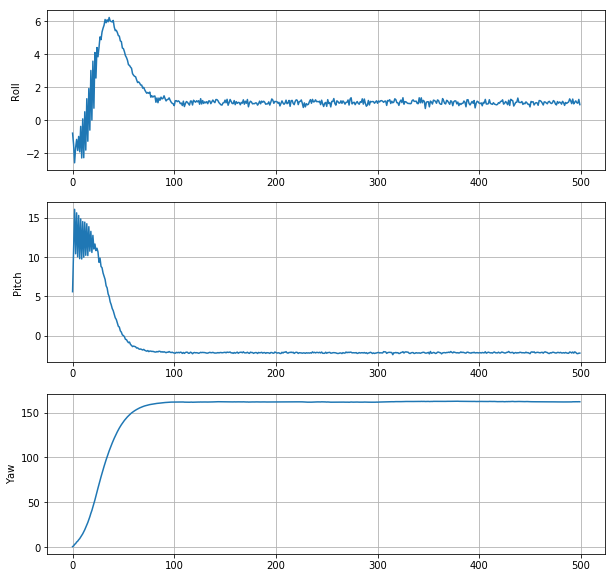

In [60]:
for i, (d, l) in enumerate(zip([save_r, save_p, save_y],['Roll','Pitch','Yaw'])):
    plt.subplot(3,1,i+1);
    plt.plot(d);
    plt.grid(True)
    plt.ylabel(l)

# Tilt Compensated Compass

Tilt compensated compass basically uses the accerlometer data to figure out the orientation of the magnetometer and proper re-align the readings as if the compass was on a flat surface. Obviously if the the compass is under going acceleration, this technique will not work. It is designed for a system essentially sitting "still" (or moving slow enough the acceleration terms are small).

In [50]:
from ins_nav.compass import TiltCompensatedCompass as TCC
compass = TCC(angle_units=TCC.DEGREES, quaternion=euler2quat(0, 0, 225, degrees=True))

save_r = []
save_p = []
save_y = []
for a, m in zip(accel, cm):
    r,p,y = compass.compensate(a,m)
    save_r.append(r)
    save_p.append(p)
    save_y.append(y)

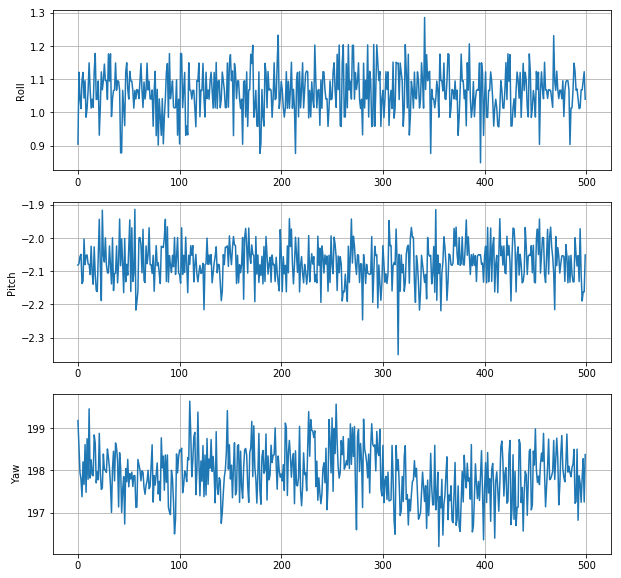

In [51]:
for i, (d, l) in enumerate(zip([save_r, save_p, save_y],['Roll','Pitch','Yaw'])):
    plt.subplot(3,1,i+1);
    plt.plot(d);
    plt.grid(True)
    plt.ylabel(l)